<a href="https://www.kaggle.com/code/vnniciusgabriel/student-depression-classification?scriptVersionId=229131495" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew, kurtosis, pearsonr
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, auc, roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

__import__('warnings').filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/student-depression-dataset/Student Depression Dataset.csv


In [2]:
df = pd.read_csv('/kaggle/input/student-depression-dataset/Student Depression Dataset.csv')

# Exploratory Data Analysis (EDA)

## 1. Variable Identification

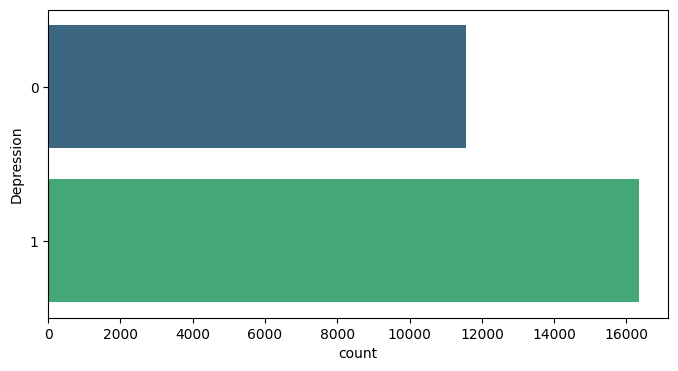

In [3]:
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.countplot(y='Depression', data=df, palette='viridis')
plt.show()

In [4]:
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [6]:
df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27898.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,3.139867,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,1.437347,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,2.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,3.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,4.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,5.000000,1.000000


## 2. Univariate Analysis

In [7]:
numerical_vars = [col for col in df.select_dtypes(include=np.number).columns.tolist() if col not in ['Depression', 'id']]
categorical_vars = df.select_dtypes(exclude=np.number).columns.tolist()

print(f"numerical columns (except id and Depression):  {' ,'.join(numerical_vars)}")
print(f"categorical columns:  {' ,'.join(categorical_vars)}")

numerical columns (except id and Depression):  Age ,Academic Pressure ,Work Pressure ,CGPA ,Study Satisfaction ,Job Satisfaction ,Work/Study Hours ,Financial Stress
categorical columns:  Gender ,City ,Profession ,Sleep Duration ,Dietary Habits ,Degree ,Have you ever had suicidal thoughts ? ,Family History of Mental Illness


### 2.1 Continuos Variables

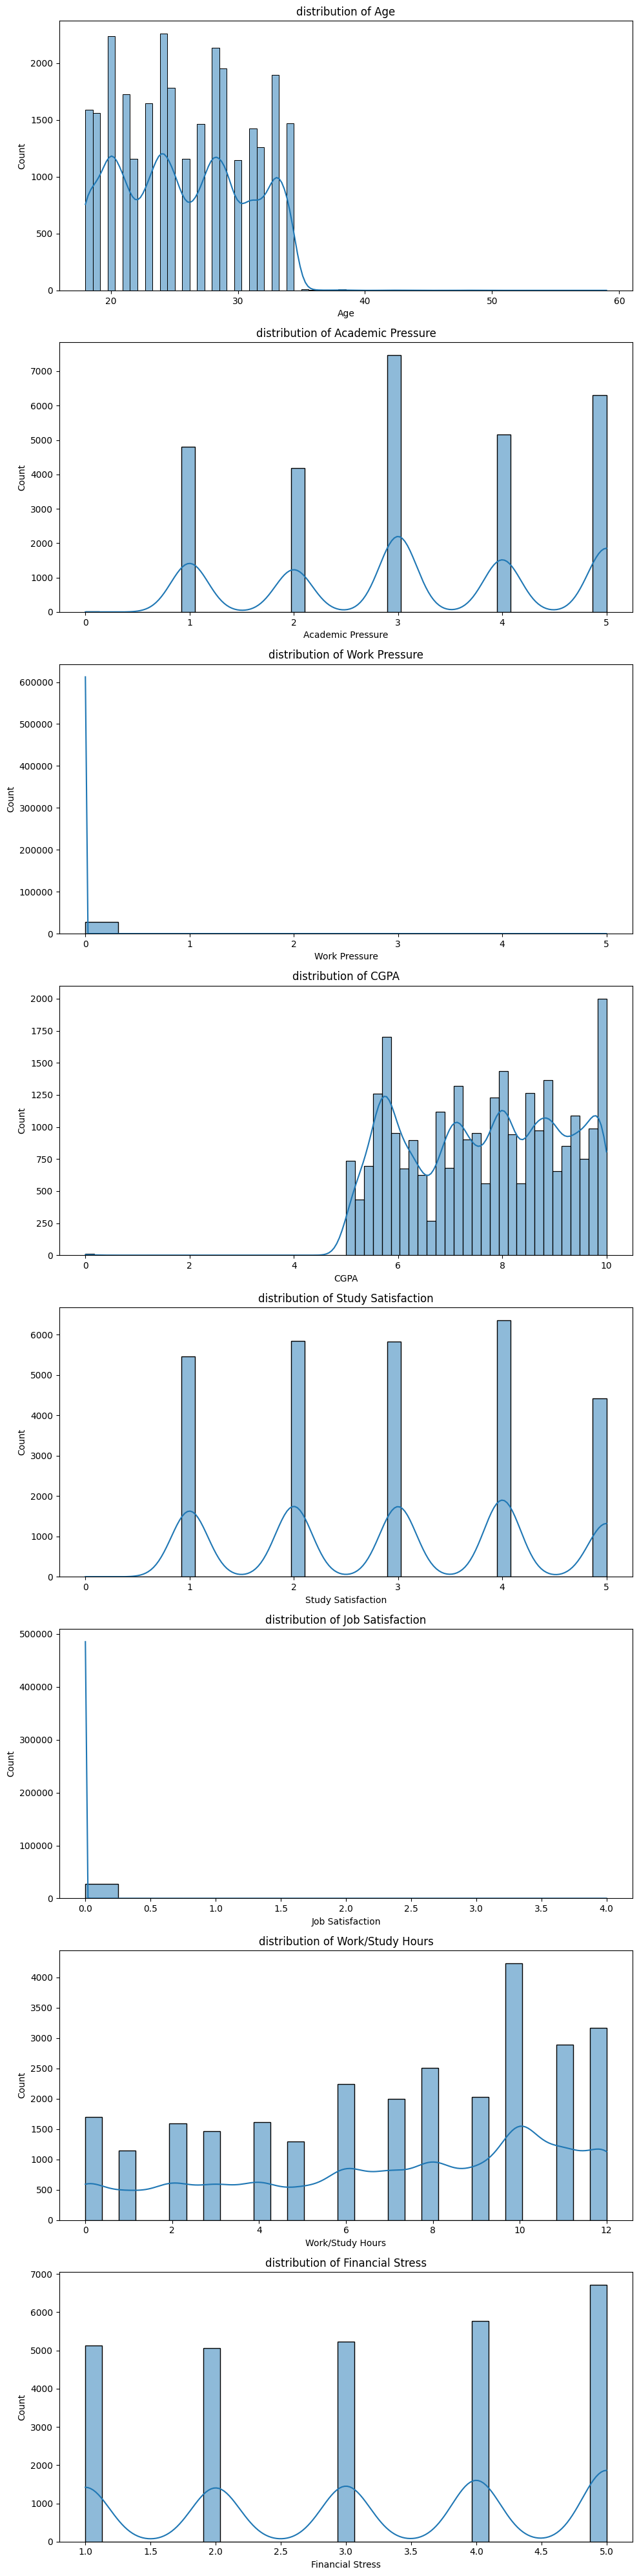

In [8]:
fix, axs = plt.subplots(nrows=len(numerical_vars), figsize=(10, 5 * len(numerical_vars)))
for i, var in enumerate(numerical_vars):
    sns.histplot(df[var], kde=True, ax=axs[i])
    axs[i].set_title(f'distribution of {var}')
plt.tight_layout()
plt.show()

### 2.2 Categorical Variables

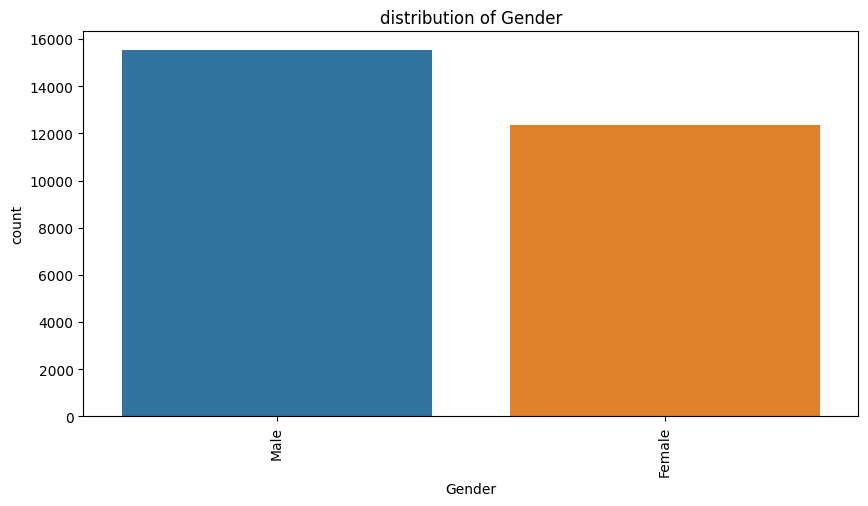

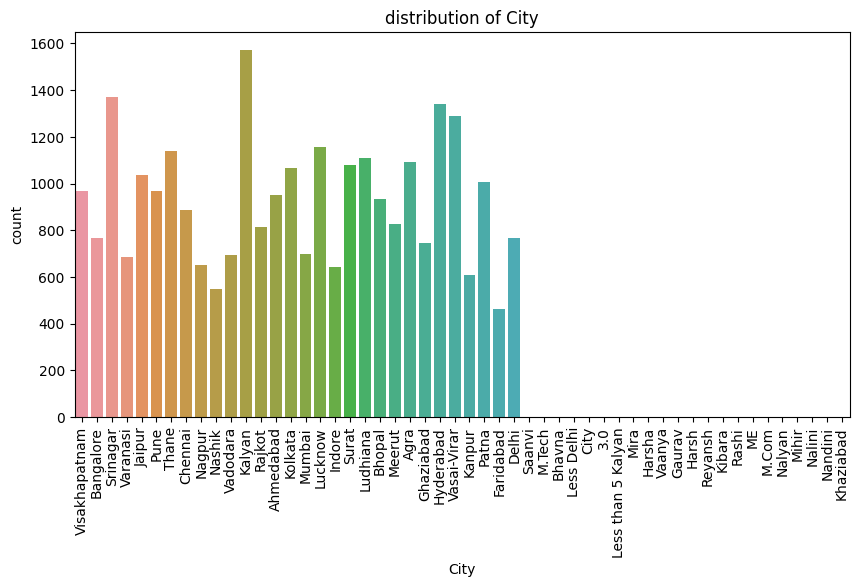

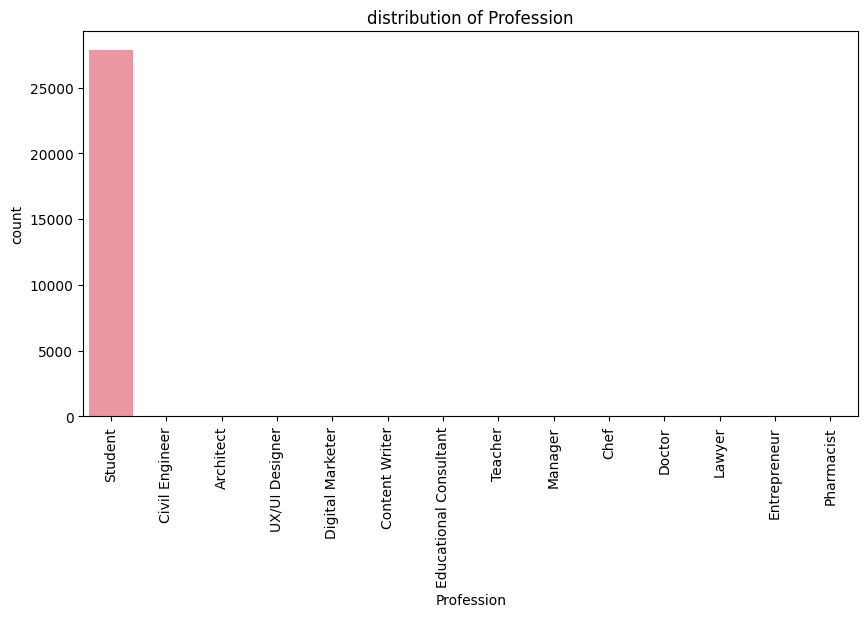

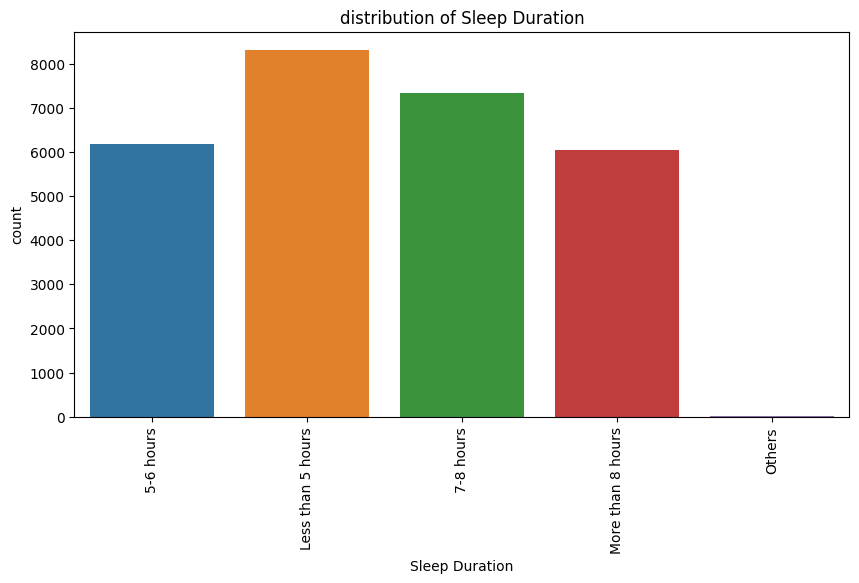

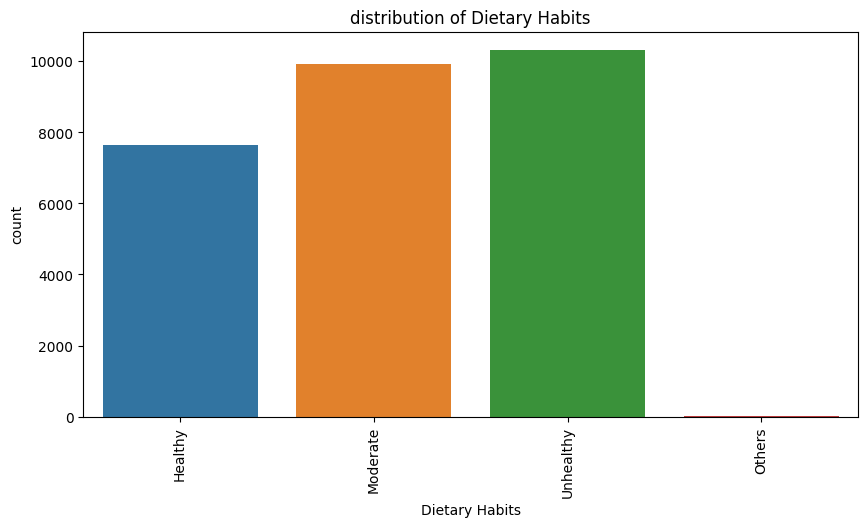

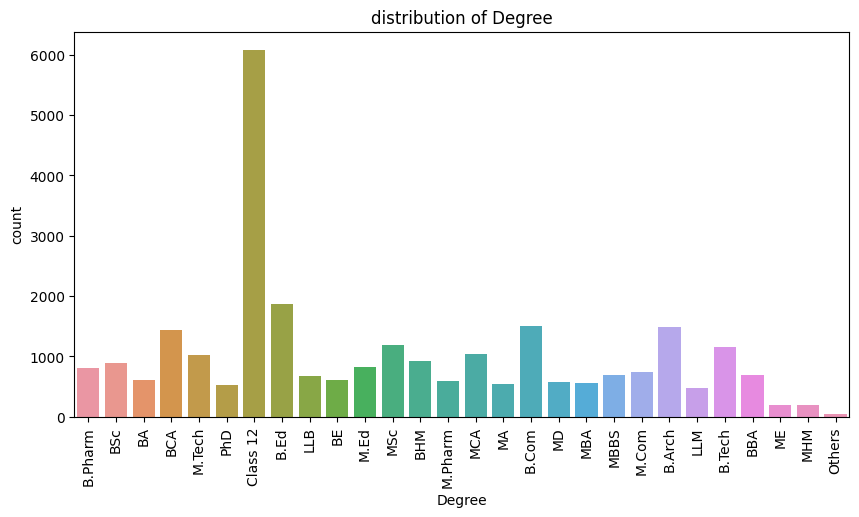

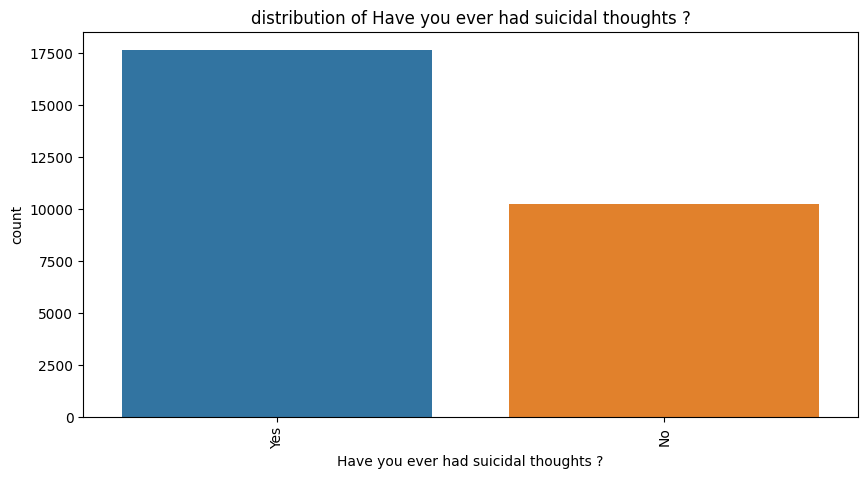

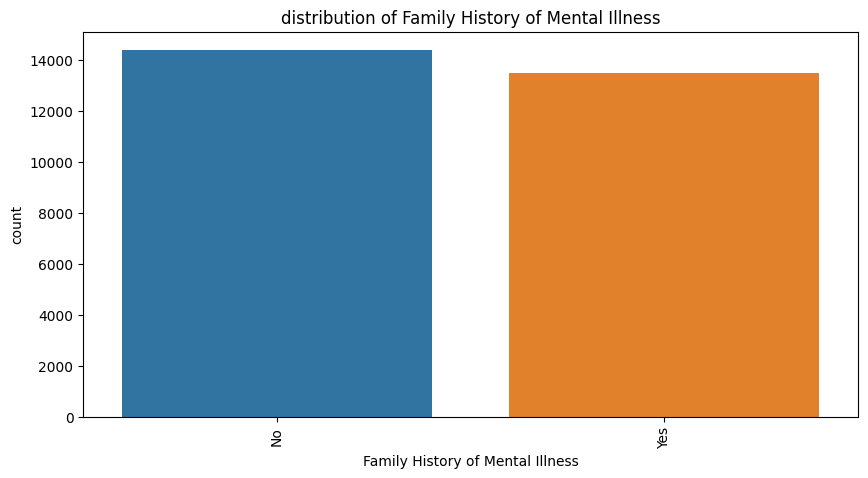

In [9]:
for var in categorical_vars:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=df[var])
    plt.title(f"distribution of {var}")
    plt.xticks(rotation=90)
    plt.show()

## 3. Bivariate Analysis

### 3.1 Continous

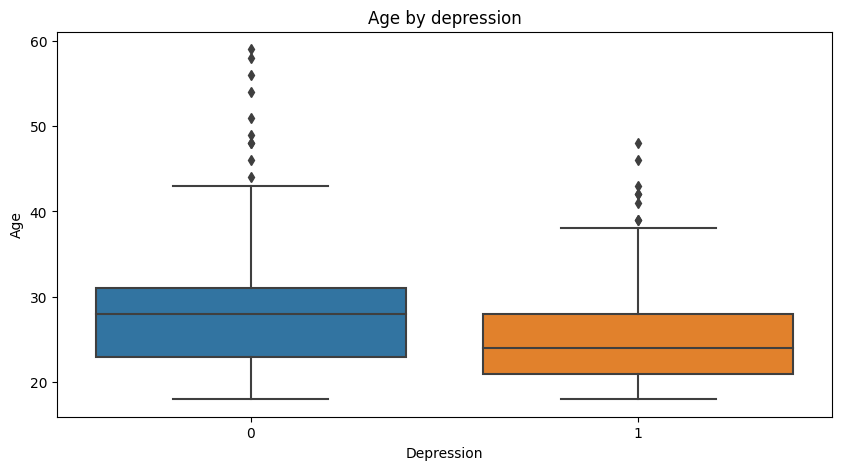

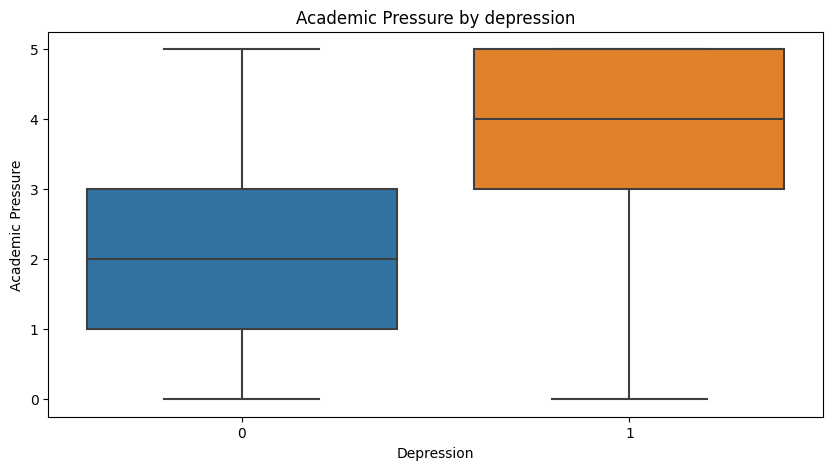

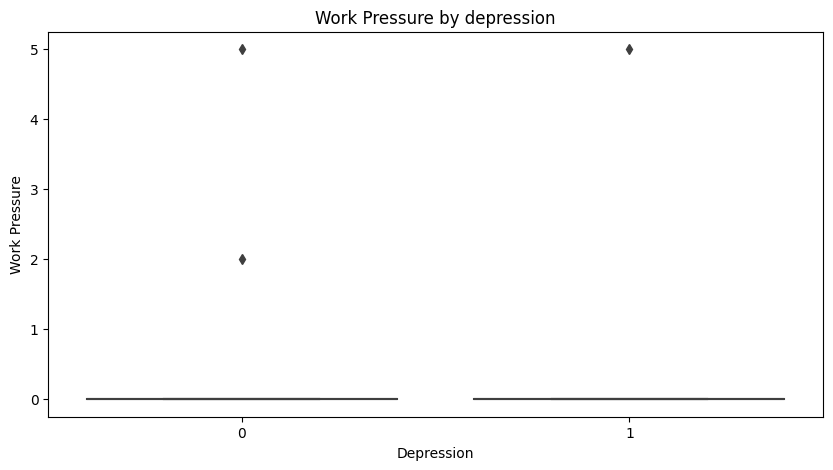

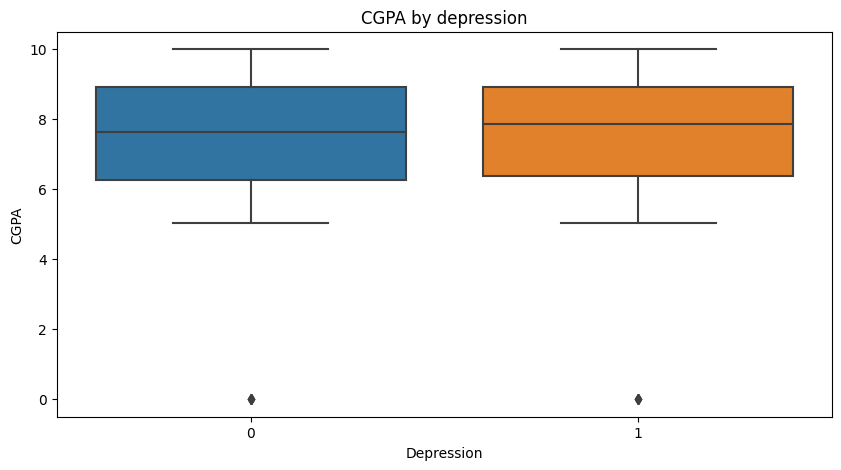

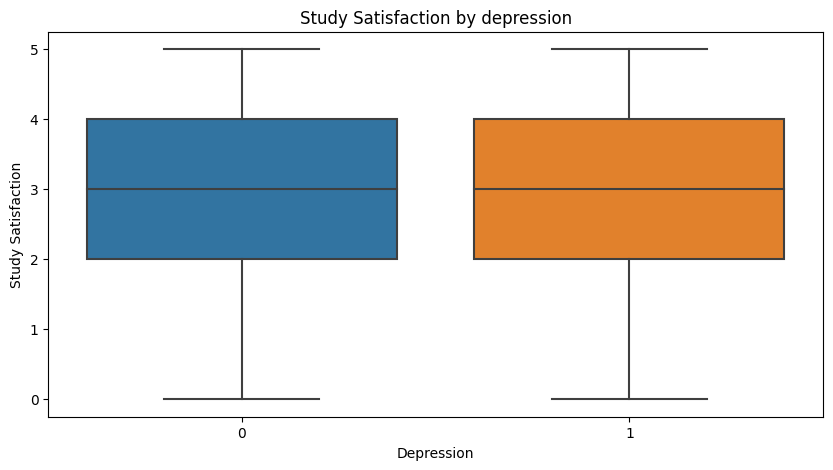

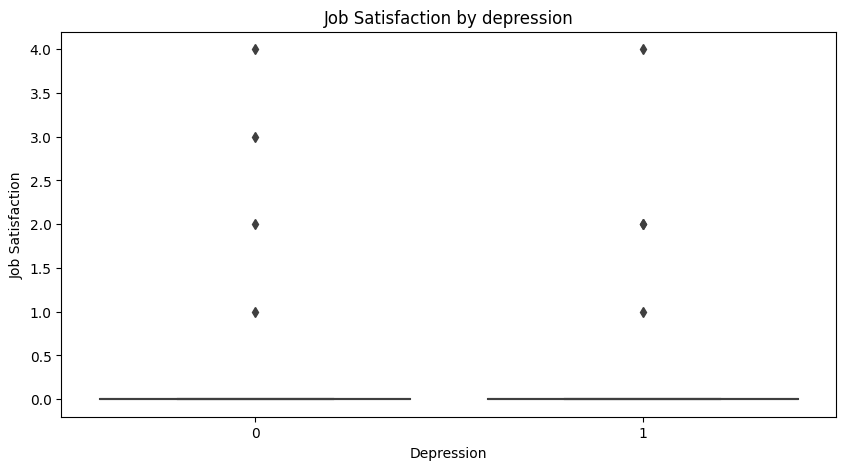

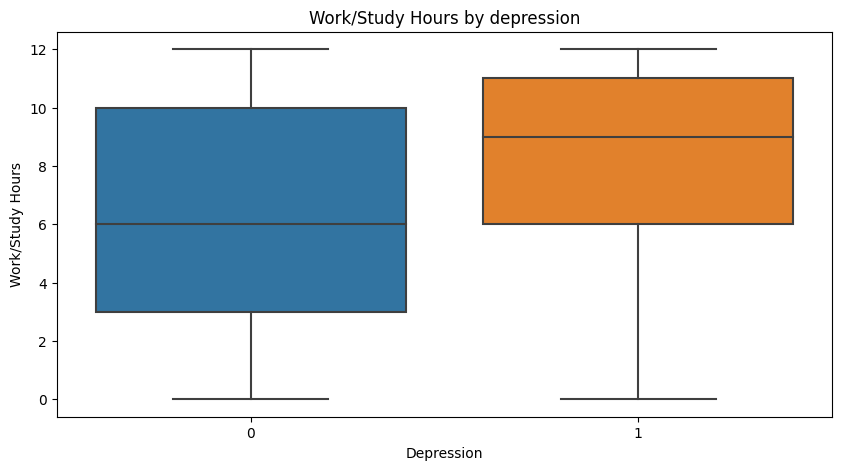

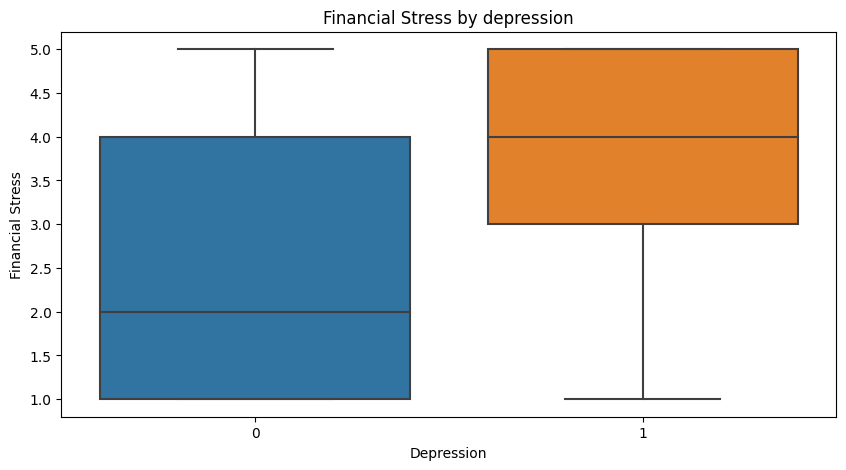

In [10]:
for var in numerical_vars:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df['Depression'], y=df[var])
    plt.title(f'{var} by depression')
    plt.show()

### 3.2 Categorical

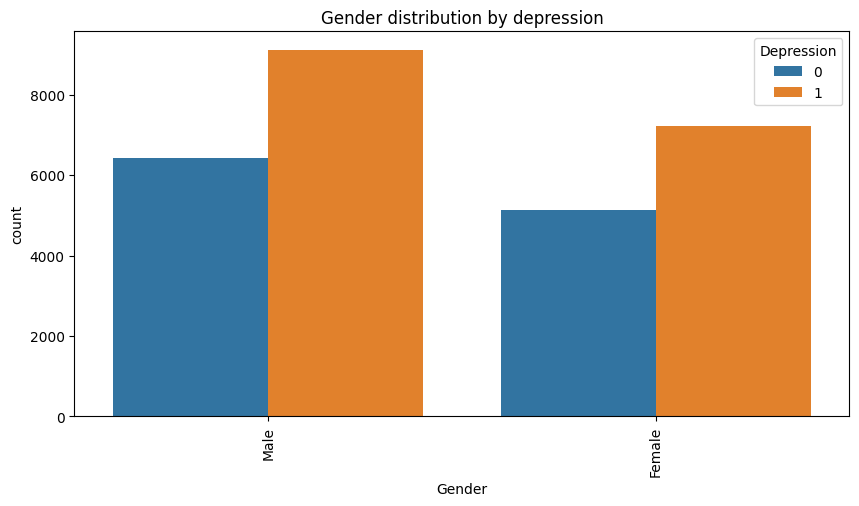

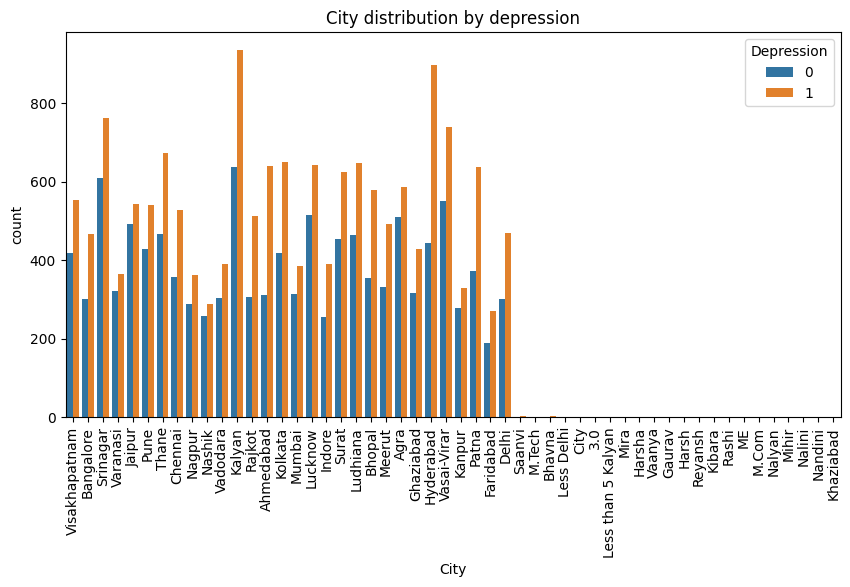

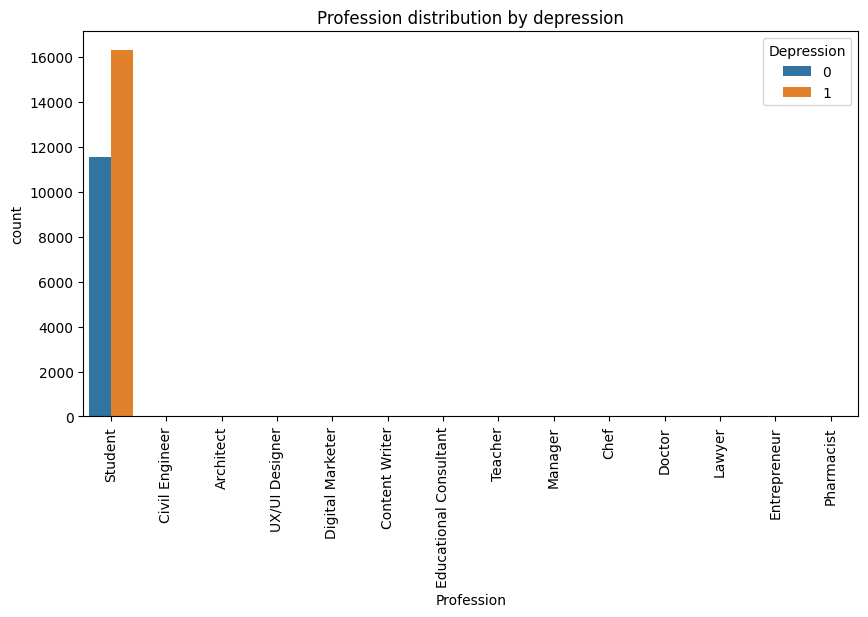

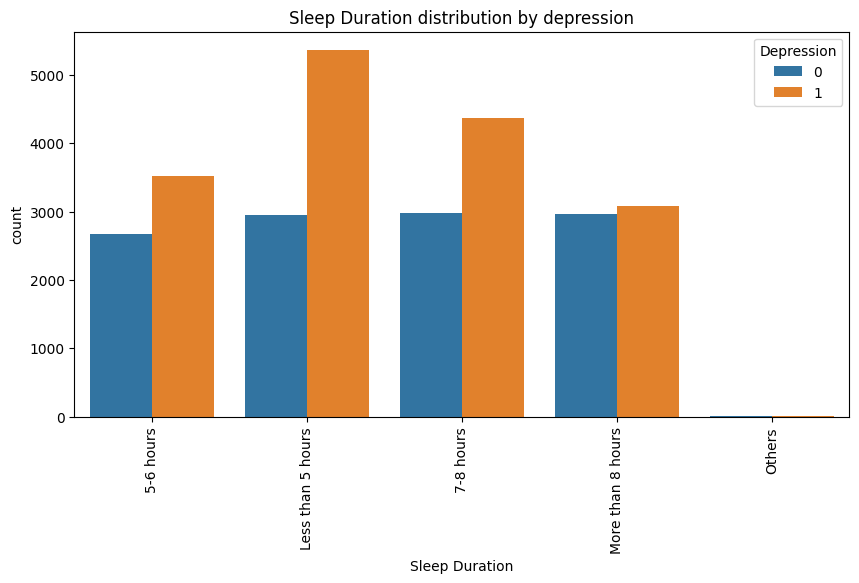

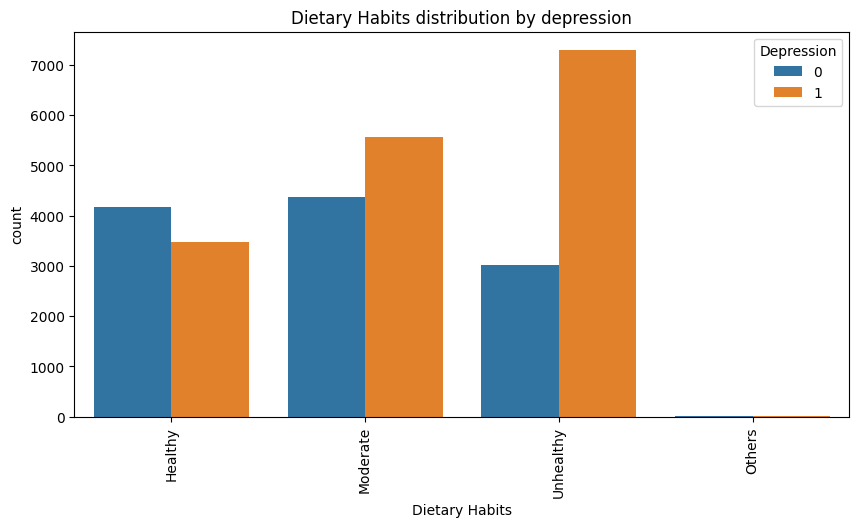

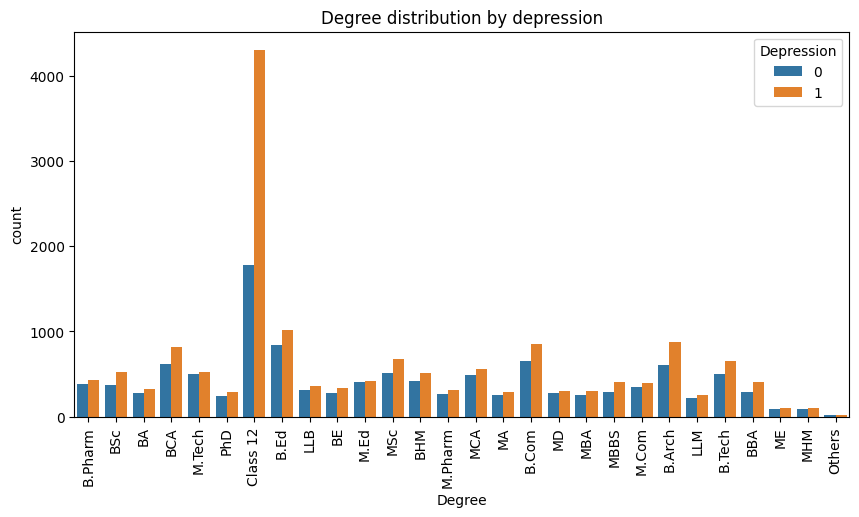

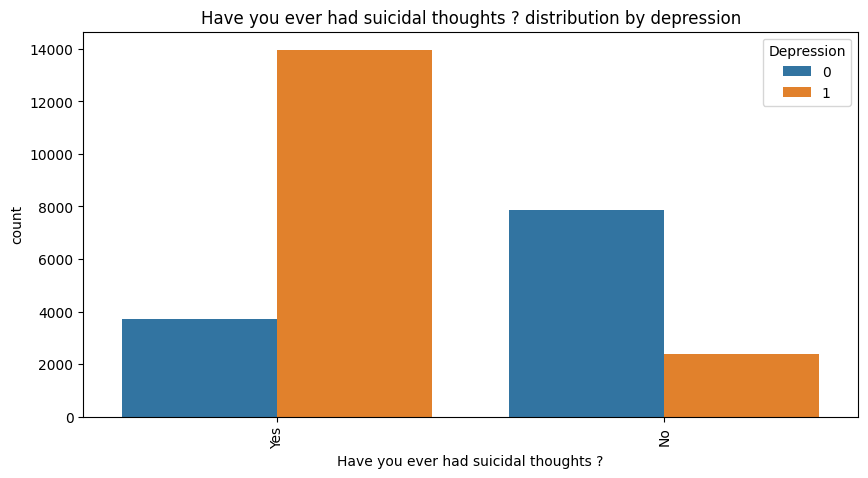

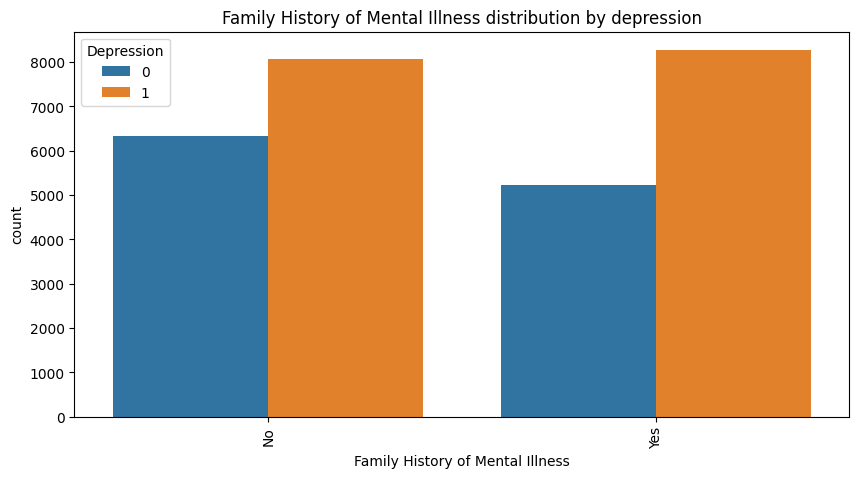

In [11]:
for var in categorical_vars:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=var, hue='Depression', data=df)
    plt.title(f'{var} distribution by depression')
    plt.xticks(rotation=90)
    plt.show()

## 4. Missing Value Treatment

In [12]:
print(f"missing values before treatment: {df.isna().sum().sum()}")

missing values before treatment: 3


### 4.1 Numerical variables

In [13]:
for var in numerical_vars:
    df[var] = df[var].fillna(df[var].median())

### 4.2 Categorical variables

In [14]:
for var in categorical_vars:
    df[var] = df[var].fillna(df[var].mode()[0])

In [15]:
print(f"missing values after treatment: {df.isna().sum().sum()}")

missing values after treatment: 0


## 5. Outlier Detection and Treatment

Age: 12 outliers detected


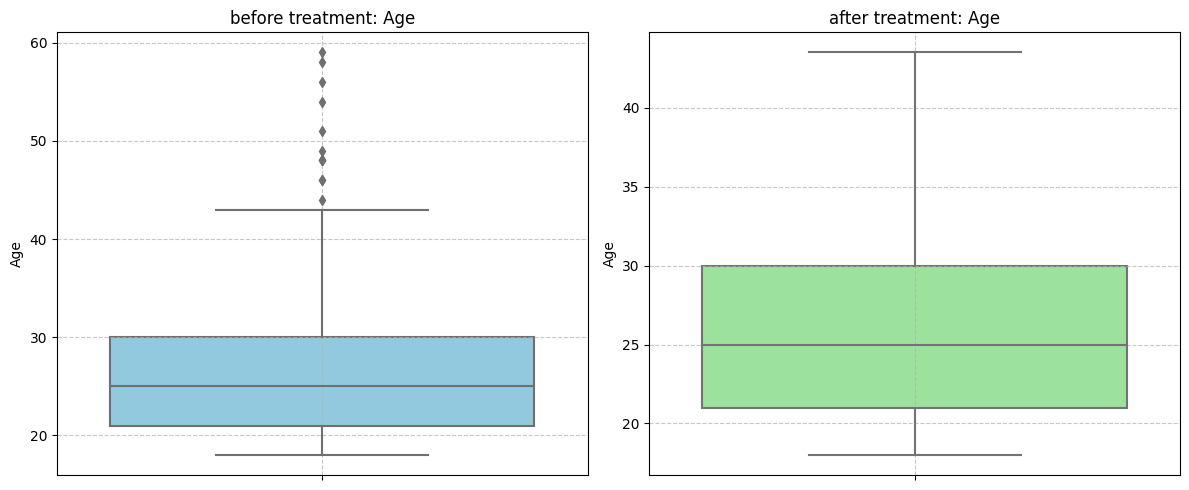

Academic Pressure: 0 outliers detected


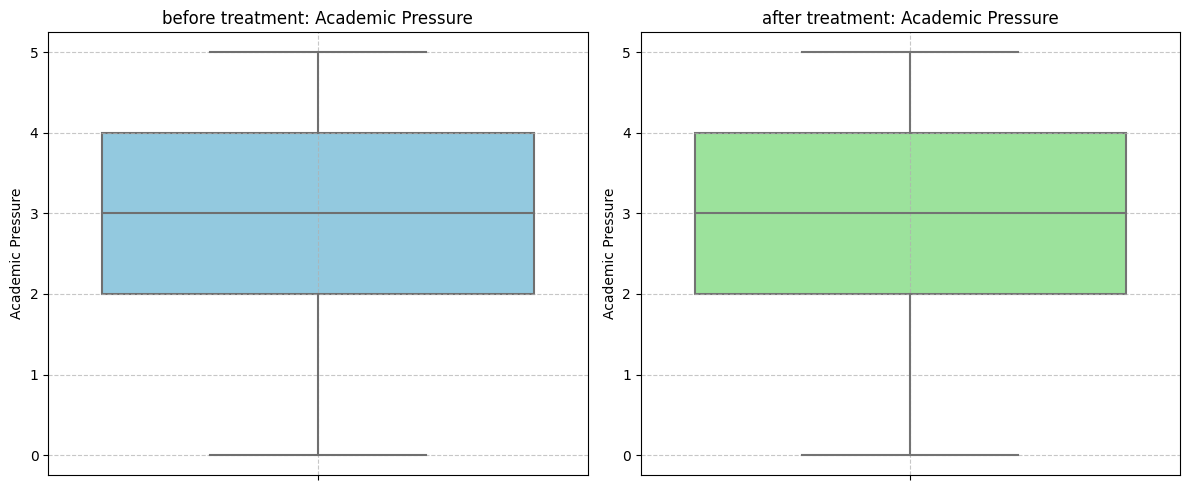

Work Pressure: 3 outliers detected


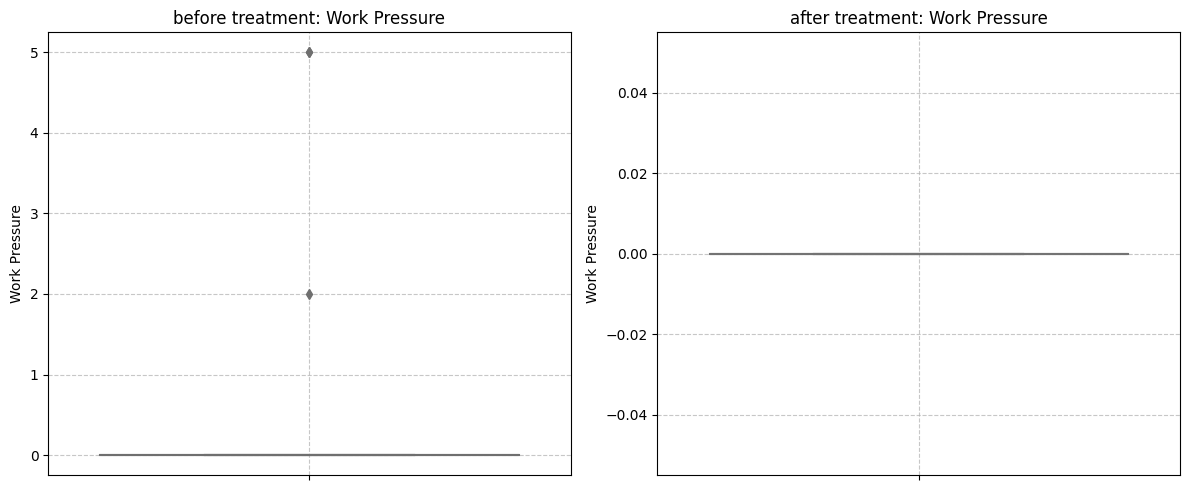

CGPA: 9 outliers detected


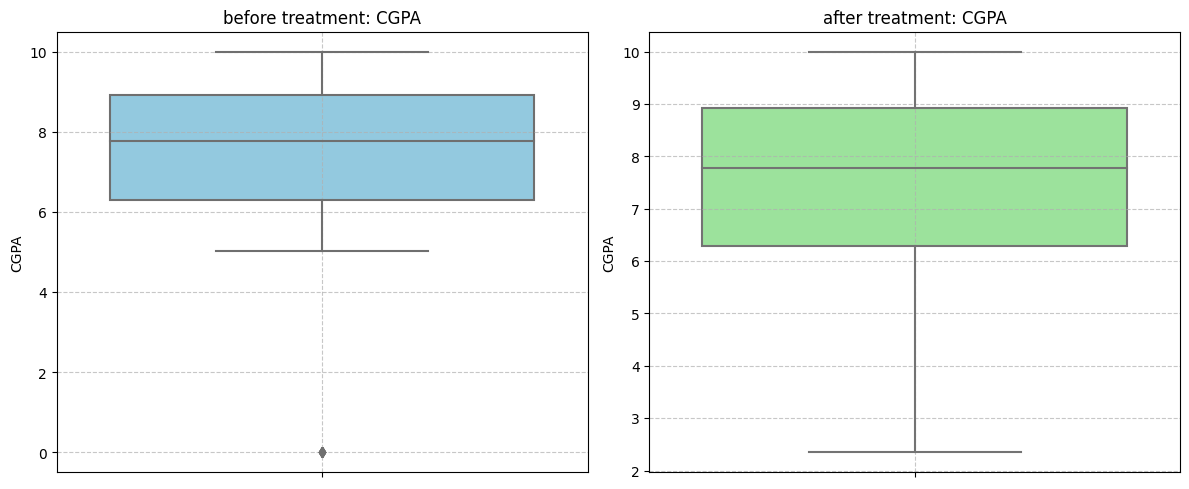

Study Satisfaction: 0 outliers detected


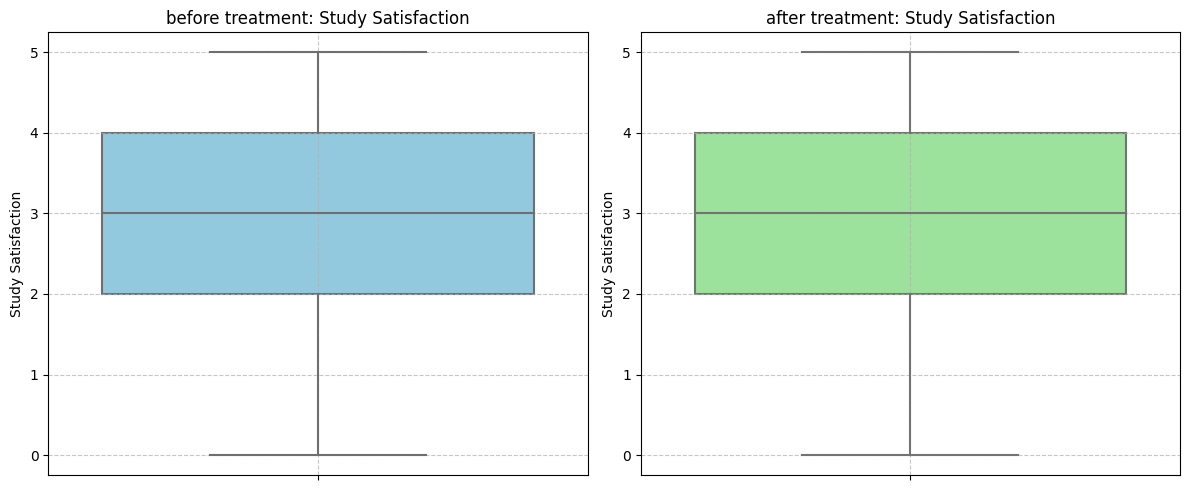

Job Satisfaction: 8 outliers detected


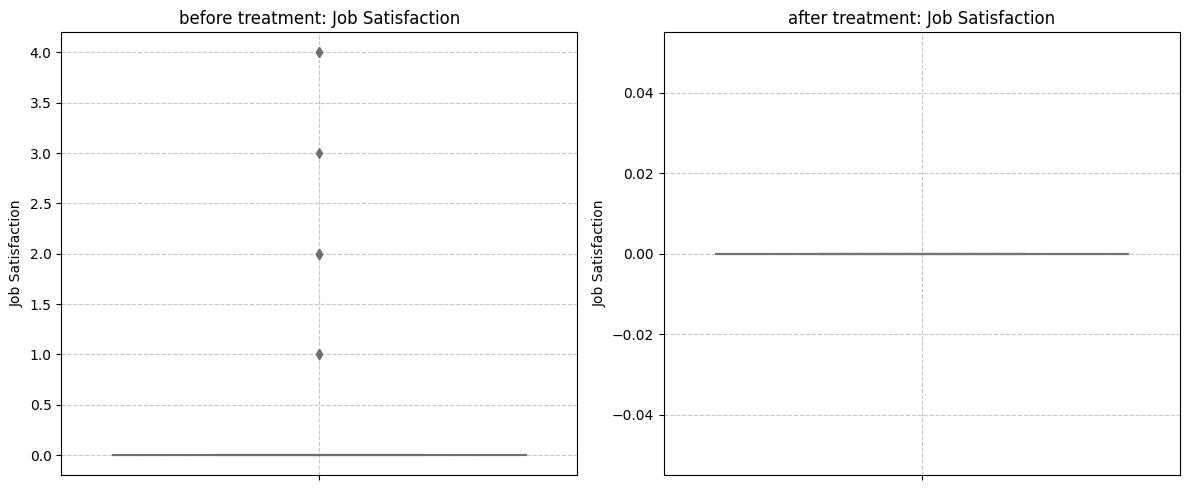

Work/Study Hours: 0 outliers detected


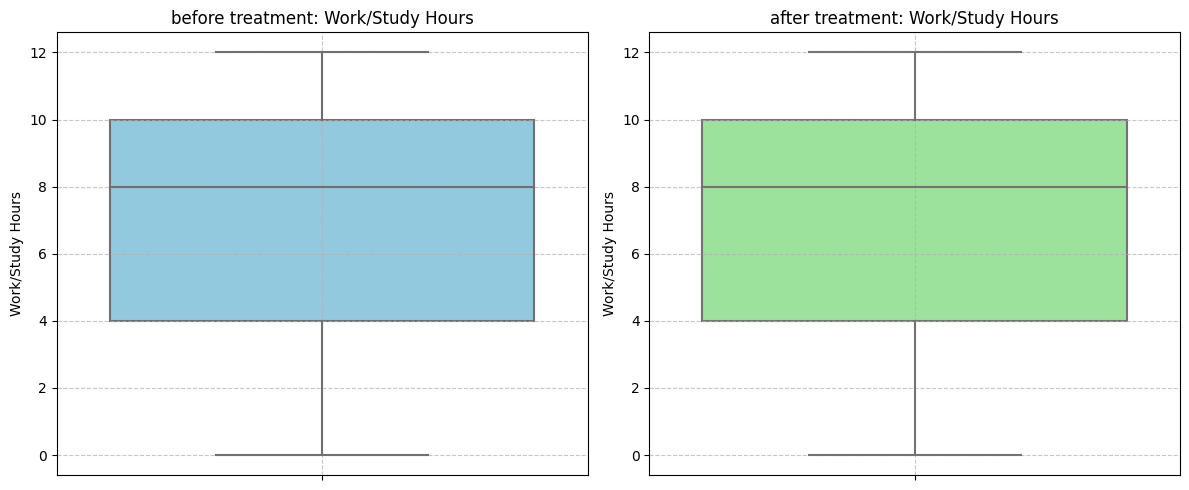

Financial Stress: 0 outliers detected


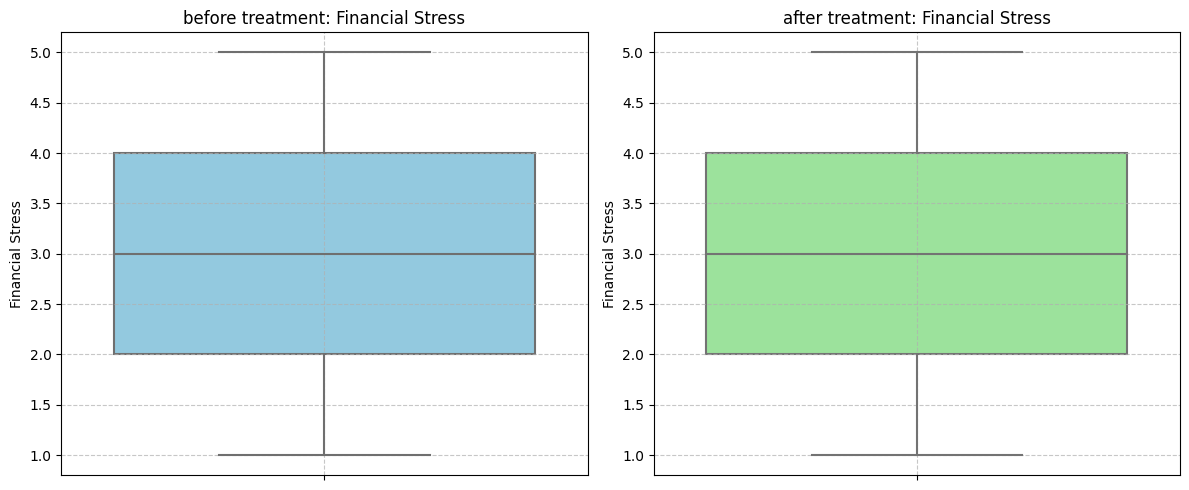

In [16]:
for var in numerical_vars:

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[var], color='skyblue')
    plt.title(f'before treatment: {var}')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    outliers = df[(df[var] < lower) | (df[var] > upper)]
    print(f"{var}: {len(outliers)} outliers detected")

    df[var] = np.where(df[var] < lower, lower, np.where(df[var] > upper, upper, df[var]))

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[var], color='lightgreen')
    plt.title(f"after treatment: {var}")
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

## 6. Data Cleaning and Transformation


final distribution
City
Kolkata         1066
Surat           1078
Agra            1094
Ludhiana        1111
Thane           1139
Lucknow         1155
Vasai-Virar     1290
Hyderabad       1340
Srinagar        1372
Kalyan          1571
Other          15685
Name: count, dtype: int64


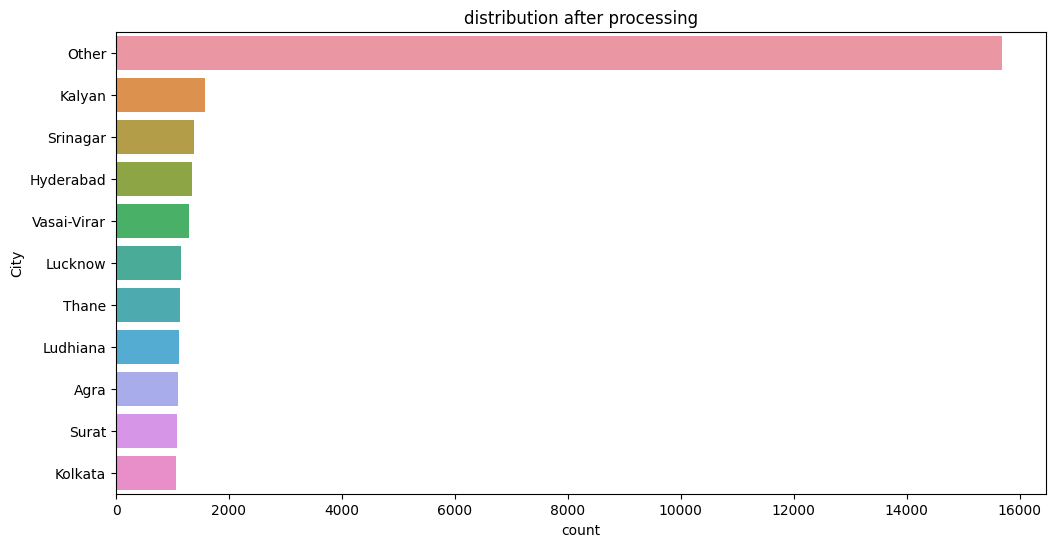

In [17]:
def process_city_column(df, 
                       anomaly_mapping=None, 
                       threshold=50, 
                       top_n=10,
                       other_label='Other'):

    if anomaly_mapping is None:
        anomaly_mapping = {
            'Less than 5 Kalyan': 'Kalyan',
            'Less Delhi': 'Delhi',
            'M.Com': other_label,
            'ME': other_label,
            '3.0': other_label
        }
    
    df = df.copy()
    df['City_original'] = df['City']
    
    df['City'] = df['City'].replace(anomaly_mapping)
    
    city_counts = df['City'].value_counts()
    
    replace_cities = city_counts[city_counts < threshold].index
    df['City'] = df['City'].replace(replace_cities, other_label)
    
    top_cities = df['City'][df['City'] != other_label].value_counts().nlargest(top_n).index
    df['City'] = np.where(df['City'].isin(top_cities), df['City'], other_label)
    
    city_order = [other_label] + list(top_cities)
    df['City'] = pd.Categorical(df['City'], categories=city_order, ordered=True)
    
    print("\nfinal distribution")
    print(df['City'].value_counts().sort_index(ascending=False))
    
    return df

df = process_city_column(df, threshold=50, top_n=10)

plt.figure(figsize=(12,6))
sns.countplot(y='City', data=df, order=df['City'].cat.categories)
plt.title('distribution after processing')
plt.show()

In [18]:
hierarchies = {
    'degree': [
        'Class 12',
        'B.Arch', 'B.Pharm', 'B.Tech', 'B.Com', 'BBA', 'BHM', 'B.Ed', 'BSc', 'BA', 'BCA', 'LLB', 'BE', 'MBBS',
        'M.Tech', 'MBA', 'MCA', 'MA', 'M.Com', 'M.Ed', 'ME', 'MHM', 'M.Pharm', 'MSc', 'LLM',
        'PhD', 'MD',
        'Others'
    ],
    'sleep': [
        'More than 8 hours',
        '7-8 hours',
        '5-6 hours',
        'Less than 5 hours',
        'Others'
    ],
    'dietary': ['Healthy', 'Moderate', 'Unhealthy', 'Others']
}

categorical_pipeline = Pipeline(steps=[
    ('encoder', ColumnTransformer(
        transformers=[
            ('binary', OrdinalEncoder(), [
                'Gender', 
                'Have you ever had suicidal thoughts ?', 
                'Family History of Mental Illness'
            ]),
            ('degree', OrdinalEncoder(categories=[hierarchies['degree']]), ['Degree']),
            ('dietary', OrdinalEncoder(categories=[hierarchies['dietary']]), ['Dietary Habits']),
            ('sleep', OrdinalEncoder(categories=[hierarchies['sleep']]), ['Sleep Duration']),
            ('categorical', OneHotEncoder(drop='first'), ['City', 'Profession'])
        ],
        remainder='drop'
    ))
])

numeric_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler())    
])

pipeline = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, categorical_vars),
        ('num', numeric_pipeline, numerical_vars)
    ],
    remainder='drop'
)

df_processed = pipeline.fit_transform(df)

## 7. Feature Engineering and Selection

In [19]:
X, y = df_processed, df['Depression']

top features com scores chi^2


,Feature,Chi2_Score,P_value
1,cat__binary__Have you ever had suicidal thoughts ?,3057.294614,0.000000
3,cat__degree__Degree,1770.214522,0.000000
36,num__Financial Stress,890.065553,0.000000
30,num__Academic Pressure,764.366685,0.000000
4,cat__dietary__Dietary Habits,691.025613,0.000000
35,num__Work/Study Hours,194.250598,0.000000
29,num__Age,171.671930,0.000000
5,cat__sleep__Sleep Duration,166.459883,0.000000
33,num__Study Satisfaction,99.083580,0.000000
2,cat__binary__Family History of Mental Illness,41.103170,0.000000


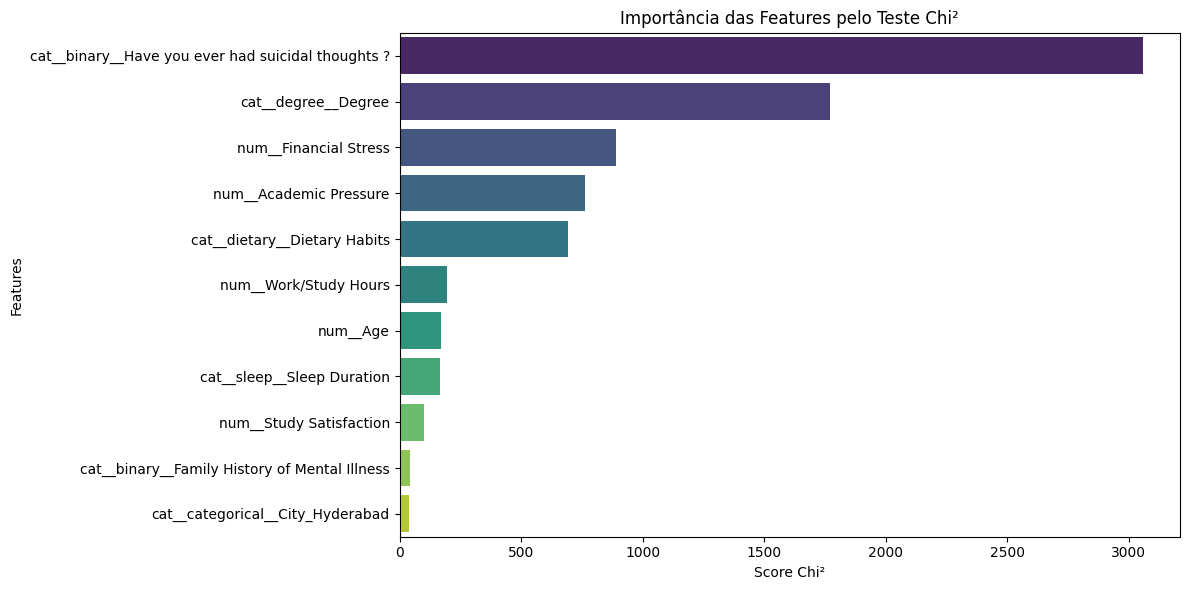

In [20]:
feature_names = pipeline.get_feature_names_out()

selector = SelectKBest(chi2, k=11)
selector.fit(X, y)

features_scores = pd.DataFrame({
    'Feature': feature_names,
    'Chi2_Score': selector.scores_,
    'P_value': selector.pvalues_
})

selected_features = feature_names[selector.get_support()]
selected_features_scores = features_scores.loc[selector.get_support()].sort_values('Chi2_Score', ascending=False)

print("top features com scores chi^2")
display(selected_features_scores.style.background_gradient(cmap='Blues', subset=['Chi2_Score']))

plt.figure(figsize=(12, 6))
sns.barplot(x='Chi2_Score', y='Feature', data=selected_features_scores, palette='viridis')
plt.title('Importância das Features pelo Teste Chi²')
plt.xlabel('Score Chi²')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## 8. Multivariate Analysis

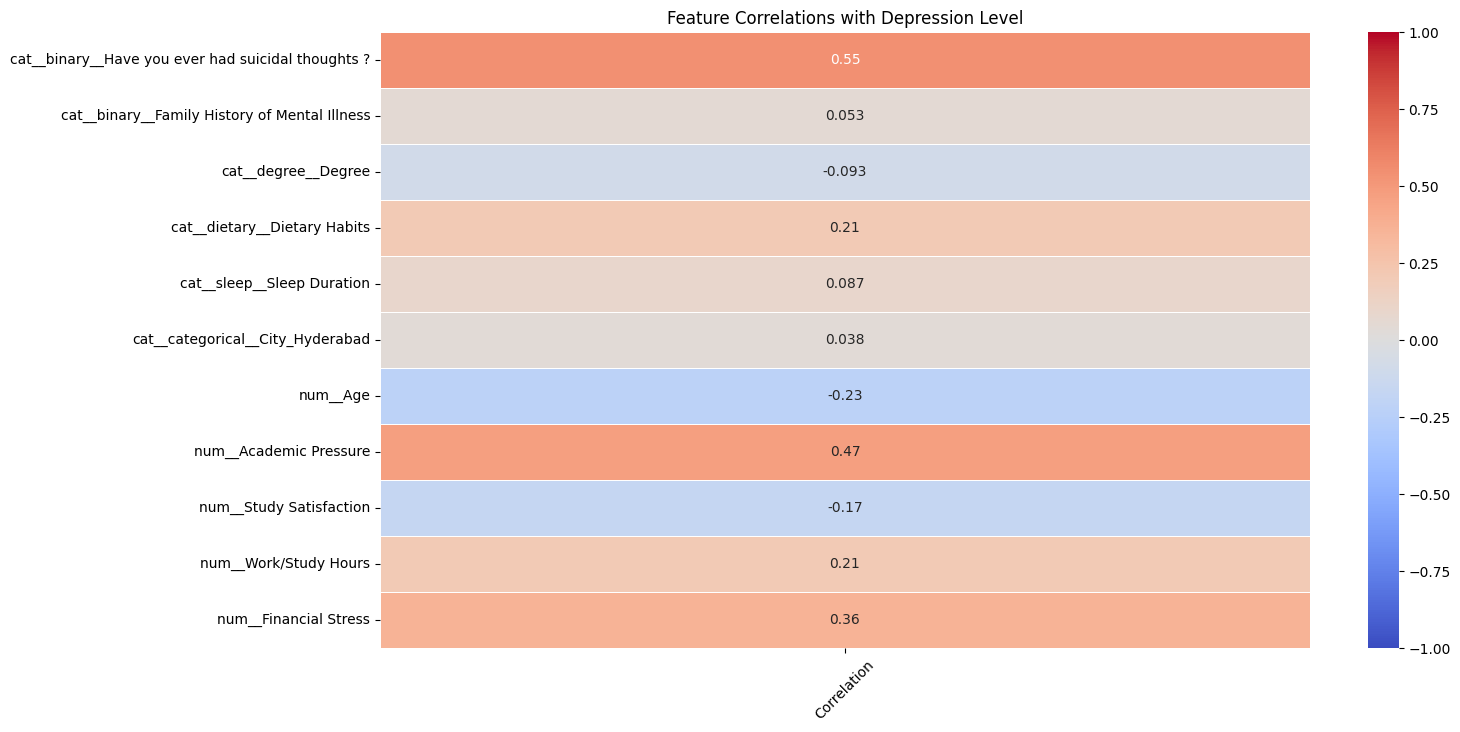

In [21]:
X = pd.DataFrame(X, columns=feature_names)[selected_features]
corr_matrix = X.corrwith(pd.Series(y))

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix.to_frame('Correlation'), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Feature Correlations with Depression Level')
plt.xticks(rotation=45)
plt.show()

## 9. Modeling Considerations

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"train size: {len(X_train)}, test_size: {len(X_test)}")

train size: 22320, test_size: 5581


# Traning and evaluating Model

In [23]:
from time import perf_counter
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = perf_counter()
        result = func(*args, **kwargs)
        print(f'{func.__name__} took {perf_counter() - start:.2f} seconds')
        return result
    return wrapper

In [24]:
@timeit
def train_model_and_evaluate(model):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    cm.plot()
    plt.grid(False)
    plt.show()

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      2343
           1       0.85      0.88      0.86      3238

    accuracy                           0.84      5581
   macro avg       0.84      0.83      0.83      5581
weighted avg       0.84      0.84      0.84      5581



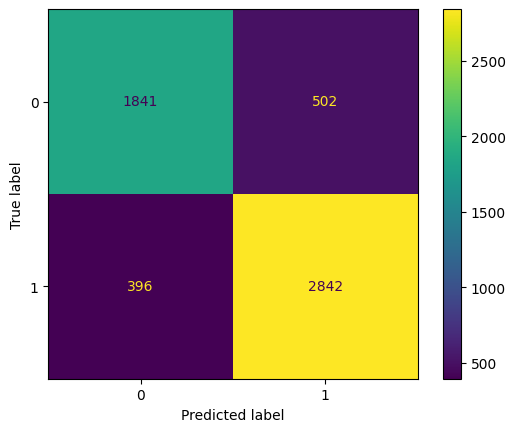

train_model_and_evaluate took 0.55 seconds


In [25]:
train_model_and_evaluate(LogisticRegression())

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2343
           1       0.84      0.86      0.85      3238

    accuracy                           0.82      5581
   macro avg       0.82      0.82      0.82      5581
weighted avg       0.82      0.82      0.82      5581



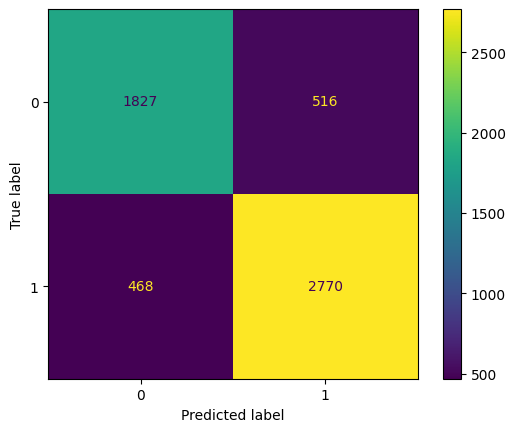

train_model_and_evaluate took 2.36 seconds


In [26]:
train_model_and_evaluate(RandomForestClassifier())

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      2343
           1       0.84      0.86      0.85      3238

    accuracy                           0.82      5581
   macro avg       0.82      0.81      0.82      5581
weighted avg       0.82      0.82      0.82      5581



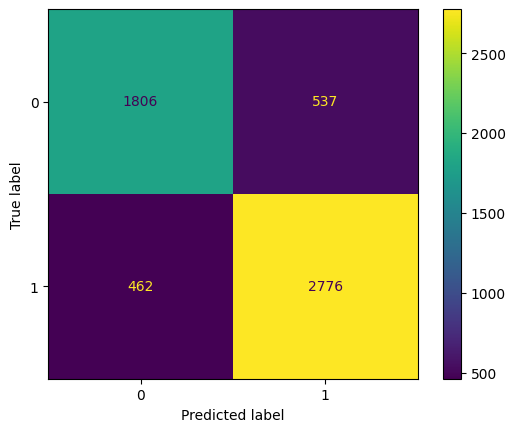

train_model_and_evaluate took 0.45 seconds


In [27]:
train_model_and_evaluate(XGBClassifier())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13098, number of negative: 9222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 22320, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.586828 -> initscore=0.350868
[LightGBM] [Info] Start training from score 0.350868
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2343
           1       0.85      0.87      0.86      3238

    accuracy                           0.83      5581
   macro avg       0.83      0.83      0.83      5581
weighted avg       0.83      0.83      0.83      5581



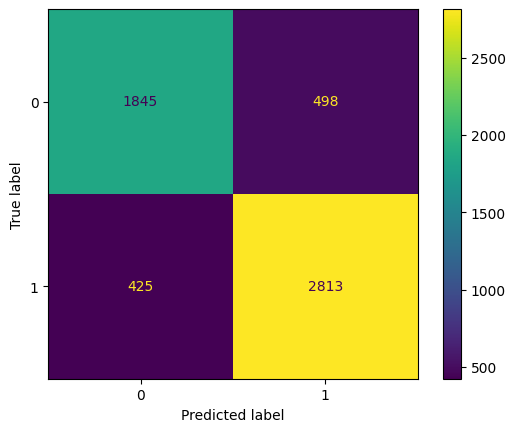

train_model_and_evaluate took 0.52 seconds


In [28]:
train_model_and_evaluate(LGBMClassifier())

In [29]:
models = {
    'LogisticRegression': LogisticRegression(),
    'LGBMClassifier': LGBMClassifier(verbosity=-1),
    'XGBClassifier': XGBClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

params = {
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
    },
    'LGBMClassifier': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 50],
        'max_depth': [-1, 5],
        'boosting_type': ['gbdt']
    },
    'XGBClassifier': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
        'objective': ['binary:logistic']
    },
    'RandomForestClassifier': {
        'n_estimators': [100, 200],
        'max_depth': [None, 5],
    }
}

best_models = {}

@timeit
def run_grid_search():
    for model_name, model in models.items():
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=params[model_name],
            cv=5,
            scoring='f1_macro',
            verbose=-1
        )
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best params for {model_name}: {grid_search.best_params_}")

run_grid_search()

Best params for LogisticRegression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best params for LGBMClassifier: {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31}
Best params for XGBClassifier: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.9}
Best params for RandomForestClassifier: {'max_depth': None, 'n_estimators': 200}
run_grid_search took 77.68 seconds


In [30]:
voting_clf = VotingClassifier(
    estimators=[(model_name, model) for model_name, model in models.items()],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

best_models['VotingClassifier'] = voting_clf

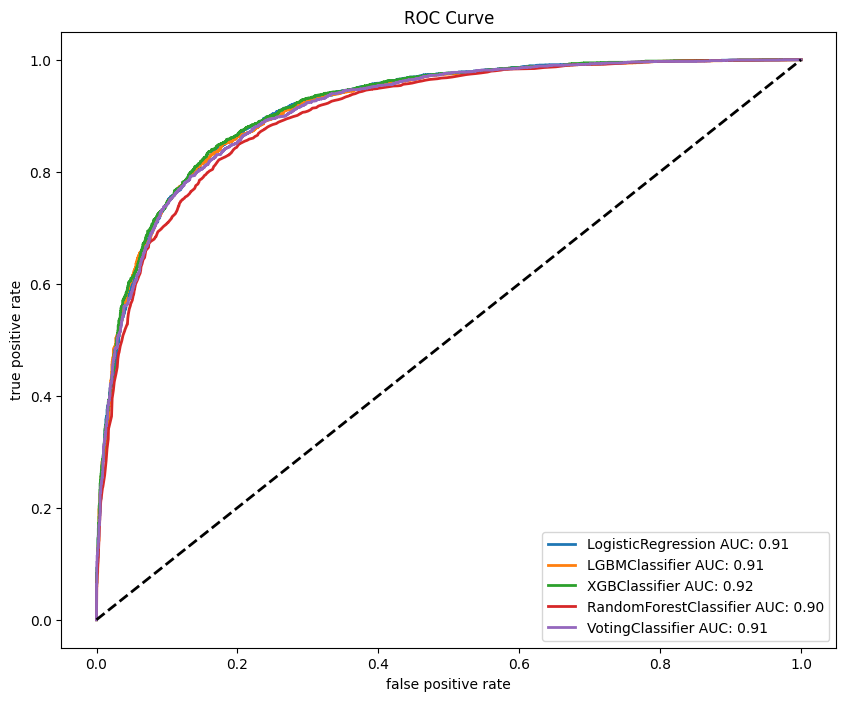

In [31]:
plt.figure(figsize=(10, 8))

for model_name, model in best_models.items():

    if hasattr(model, "predict_proba"):
        y_pred = model.predict_proba(X_test)[:, 1]
    else:
        y_pred = model.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{model_name} AUC: {auc_score:.2f}")

plt.plot([0, 1], [0, 1], '--k', lw=2)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      2343
           1       0.85      0.88      0.86      3238

    accuracy                           0.84      5581
   macro avg       0.84      0.83      0.83      5581
weighted avg       0.84      0.84      0.84      5581



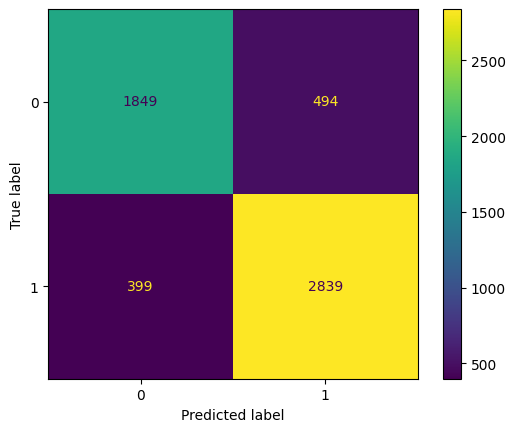

In [32]:
model = best_models['XGBClassifier']

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cm.plot()
plt.grid(False)
plt.show()

# XGBClassifier is the best overall model since it has a strong balance of precision, recall, and F1-score, while also maintaining high accuracy (84%)